### Project Description


The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

### Proposed Work Plan

1. Preprocessing for EDA:
    - Lowercase column names
    - Change enddate and begindate to date dtype
    - Change totalcharges to float dtype
    - Change seniorcitizen to object dtype
    - Merge data from all csv files using an outer merge on customerID
    - Check null values and duplicates
    - Churn column with binary value as target
2. EDA:
      - Class distribution
      - Plot Churn against other features for possible correlation
2. Feature engineering:
    - Days with company
    - Number of services
3. Preprocessing for ML:
    - Perform one-hot encoding on categorical columns
    - Scale numerical columns
    - Deal with class imbalance
4. Model Training & Evaluation
    - Logistical Regression
    - Decision Tree Regressor
    - Random Forest Regressor
    - LightGBM
    - Keras neural network
5. Model Tuning
    - Pick best models from above and perform hyperparameter tuning
    - Evaluate tuned model
6. Conclusions
    - Best model to be used to predict customer churn
    - Suggestions on how to keep customers who are about to churn from leaving

### Preprocessing for EDA

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

In [44]:
directory_path = './final_provider/'

# get a list of all CSV files in the directory
files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
files.sort()

# your ordered list of names
names = ['contract_df', 'internet_df', 'personal_df', 'phone_df']

# read each file into a pandas dataframe and store it in the dictionary
for f, name in zip(files, names):
    globals()[name] = pd.read_csv(os.path.join(directory_path, f))

In [54]:
contract_df

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [53]:
contract_df.columns = contract_df.columns.str.lower()

In [58]:
phone_df

,customerid,multiplelines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [57]:
phone_df.columns = phone_df.columns.str.lower()

In [59]:
personal_df

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [48]:
personal_df.columns = personal_df.columns.str.lower()

In [60]:
internet_df

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [50]:
internet_df.columns = internet_df.columns.str.lower()

In [61]:
# Merge all dataframes into one based on 'customerID'
df = pd.merge(personal_df, contract_df, on='customerid', how='outer')
df = pd.merge(df, internet_df, on='customerid', how='outer')
df = pd.merge(df, phone_df, on='customerid', how='outer')

# Display the first few rows of the merged dataframe
df.head(10)

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,Female,0,No,No,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,Male,0,No,Yes,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,Female,0,No,No,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,Female,0,Yes,No,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,Male,0,No,Yes,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,DSL,Yes,Yes,No,No,No,No,No


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   begindate         7043 non-null   object 
 6   enddate           7043 non-null   object 
 7   type              7043 non-null   object 
 8   paperlessbilling  7043 non-null   object 
 9   paymentmethod     7043 non-null   object 
 10  monthlycharges    7043 non-null   float64
 11  totalcharges      7043 non-null   object 
 12  internetservice   5517 non-null   object 
 13  onlinesecurity    5517 non-null   object 
 14  onlinebackup      5517 non-null   object 
 15  deviceprotection  5517 non-null   object 
 16  techsupport       5517 non-null   object 


There are null values as a result of doing outer merge that need to be dealt with. totalcharges dtype is object and should be converted to float. begindate and enddate should be converted to datetime dtype. semiorcitizen should be changed to object dtype.

In [13]:
# Convert 'TotalCharges' to numeric type and handle any non-numeric values
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')

# Convert begindate & enddate to date dtype
df['begindate'] = pd.to_datetime(df['begindate'])
df['enddate'] = pd.to_datetime(df['enddate'], errors='coerce')

# Convert seniorcitizen column values to 'Yes' if 1 and 'No' if 0
df['seniorcitizen'] = df['seniorcitizen'].map({1: 'Yes', 0: 'No'})

Create a target variable named Churn based on the EndDate column. If EndDate is 'NaT', we set Churn as 0 (meaning the customer has not churned). Otherwise, we set Churn as 1 (meaning the customer has churned).

In [14]:
# Create 'churn' feature, 0 for active users, 1 for terminated
df['churn'] = (~df['enddate'].isna()).astype(int)

# Check few rows of the dataframe
df.sample(10)

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,...,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,churn
1470,6979-TNDEU,Female,No,No,No,2019-06-01,NaT,Month-to-month,No,Mailed check,...,156.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
4669,8701-DGLVH,Male,No,No,No,2015-11-01,NaT,Two year,No,Mailed check,...,1042.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
942,7567-ECMCM,Male,No,No,No,2018-02-01,NaT,Month-to-month,Yes,Credit card (automatic),...,2001.00,Fiber optic,No,No,No,No,No,Yes,No,0
799,3009-JWMPU,Male,No,No,No,2014-11-01,2020-01-01,One year,Yes,Electronic check,...,6125.40,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,1
2562,0277-ORXQS,Male,No,Yes,Yes,2014-08-01,NaT,Two year,No,Bank transfer (automatic),...,3364.55,DSL,No,No,No,Yes,Yes,Yes,NaN,0
535,5348-CAGXB,Male,No,No,No,2019-02-01,NaT,Month-to-month,Yes,Electronic check,...,1021.75,Fiber optic,No,No,Yes,No,Yes,No,Yes,0
2347,7089-RKVSZ,Male,No,Yes,Yes,2019-06-01,NaT,One year,No,Mailed check,...,203.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
6857,1930-WNXSB,Male,No,Yes,Yes,2015-04-01,NaT,Month-to-month,Yes,Electronic check,...,5305.05,Fiber optic,No,Yes,No,No,Yes,Yes,No,0
3569,9847-HNVGP,Male,No,No,No,2018-09-01,NaT,One year,No,Mailed check,...,310.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
3786,0064-YIJGF,Male,No,Yes,Yes,2017-11-01,NaT,Month-to-month,Yes,Bank transfer (automatic),...,1929.00,Fiber optic,No,No,No,No,No,No,Yes,0


In [15]:
# Add longevity feature by calculating enddate - begindate. For active customers, enddate is max value in enddate column

# Replace NaT values in 'enddate' with the maximum value
df['enddate'] = df['enddate'].fillna(df['enddate'].max())

# Calculate the difference between 'enddate' and 'begindate'
df['longevity'] = (df['enddate'] - df['begindate']).dt.days
df

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,...,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,churn,longevity
0,7590-VHVEG,Female,No,Yes,No,2020-01-01,2020-01-01,Month-to-month,Yes,Electronic check,...,DSL,No,Yes,No,No,No,No,NaN,0,0
1,5575-GNVDE,Male,No,No,No,2017-04-01,2020-01-01,One year,No,Mailed check,...,DSL,Yes,No,Yes,No,No,No,No,0,1005
2,3668-QPYBK,Male,No,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,...,DSL,Yes,Yes,No,No,No,No,No,1,61
3,7795-CFOCW,Male,No,No,No,2016-05-01,2020-01-01,One year,No,Bank transfer (automatic),...,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1340
4,9237-HQITU,Female,No,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,...,Fiber optic,No,No,No,No,No,No,No,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,No,Yes,Yes,2018-02-01,2020-01-01,One year,Yes,Mailed check,...,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0,699
7039,2234-XADUH,Female,No,Yes,Yes,2014-02-01,2020-01-01,One year,Yes,Credit card (automatic),...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0,2160
7040,4801-JZAZL,Female,No,Yes,Yes,2019-03-01,2020-01-01,Month-to-month,Yes,Electronic check,...,DSL,Yes,No,No,No,No,No,NaN,0,306
7041,8361-LTMKD,Male,Yes,Yes,No,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,...,Fiber optic,No,No,No,No,No,No,Yes,1,123


In [16]:
# Drop enddate column as it's no longer needed
df = df.drop(columns='enddate')

In [17]:
# Check unique values for the columns with missing values
cols_with_missing_values = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 
                            'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

for col in cols_with_missing_values:
    print(f"Unique values for {col}: {df[col].unique()}\n")

Unique values for internetservice: ['DSL' 'Fiber optic' nan]

Unique values for onlinesecurity: ['No' 'Yes' nan]

Unique values for onlinebackup: ['Yes' 'No' nan]

Unique values for deviceprotection: ['No' 'Yes' nan]

Unique values for techsupport: ['No' 'Yes' nan]

Unique values for streamingtv: ['No' 'Yes' nan]

Unique values for streamingmovies: ['No' 'Yes' nan]

Unique values for multiplelines: [nan 'No' 'Yes']



The missing values in these columns represent customers who are not subscribed to the corresponding service. We'll fill them with 'No'.

In [18]:
# Fill missing values with 'No'
cols_with_missing_values = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']
df[cols_with_missing_values] = df[cols_with_missing_values].fillna('No')

# Check for missing values in the dataframe again
df.isnull().sum()

customerid           0
gender               0
seniorcitizen        0
partner              0
dependents           0
begindate            0
type                 0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
multiplelines        0
churn                0
longevity            0
dtype: int64

In [19]:
# Check 'BeginDate' for rows with missing 'TotalCharges'
df[df['totalcharges'].isnull()]['begindate']

488    2020-02-01
753    2020-02-01
936    2020-02-01
1082   2020-02-01
1340   2020-02-01
3331   2020-02-01
3826   2020-02-01
4380   2020-02-01
5218   2020-02-01
6670   2020-02-01
6754   2020-02-01
Name: begindate, dtype: datetime64[ns]

All customers with missing TotalCharges have a contract start date of 2020-02-01, so they are new customers who haven't been charged yet. Filling the missing values in TotalCharges with 0.

In [20]:
# Fill missing values in 'TotalCharges' with 0
df['totalcharges'] = df['totalcharges'].fillna(0)

# Check for any missing values
df.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
begindate           0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
multiplelines       0
churn               0
longevity           0
dtype: int64

In [21]:
# List of services
services = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 
            'techsupport', 'streamingtv', 'streamingmovies']

# Create a new column 'additional_services' that counts the number of 'Yes' responses in the service columns for each row
df['additional_services'] = df[services].apply(lambda x: x == 'Yes').sum(axis=1)

# Display the first few rows of the dataframe with the new 'service_count' column
df.head(10)

,customerid,gender,seniorcitizen,partner,dependents,begindate,type,paperlessbilling,paymentmethod,monthlycharges,...,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,churn,longevity,additional_services
0,7590-VHVEG,Female,No,Yes,No,2020-01-01,Month-to-month,Yes,Electronic check,29.85,...,No,Yes,No,No,No,No,No,0,0,1
1,5575-GNVDE,Male,No,No,No,2017-04-01,One year,No,Mailed check,56.95,...,Yes,No,Yes,No,No,No,No,0,1005,2
2,3668-QPYBK,Male,No,No,No,2019-10-01,Month-to-month,Yes,Mailed check,53.85,...,Yes,Yes,No,No,No,No,No,1,61,2
3,7795-CFOCW,Male,No,No,No,2016-05-01,One year,No,Bank transfer (automatic),42.30,...,Yes,No,Yes,Yes,No,No,No,0,1340,3
4,9237-HQITU,Female,No,No,No,2019-09-01,Month-to-month,Yes,Electronic check,70.70,...,No,No,No,No,No,No,No,1,61,0
5,9305-CDSKC,Female,No,No,No,2019-03-01,Month-to-month,Yes,Electronic check,99.65,...,No,No,Yes,No,Yes,Yes,Yes,1,245,3
6,1452-KIOVK,Male,No,No,Yes,2018-04-01,Month-to-month,Yes,Credit card (automatic),89.10,...,No,Yes,No,No,Yes,No,Yes,0,640,2
7,6713-OKOMC,Female,No,No,No,2019-04-01,Month-to-month,No,Mailed check,29.75,...,Yes,No,No,No,No,No,No,0,275,1
8,7892-POOKP,Female,No,Yes,No,2017-07-01,Month-to-month,Yes,Electronic check,104.80,...,No,No,Yes,Yes,Yes,Yes,Yes,1,853,4
9,6388-TABGU,Male,No,No,Yes,2014-12-01,One year,No,Bank transfer (automatic),56.15,...,Yes,Yes,No,No,No,No,No,0,1857,2


In [22]:
# Move 'churn' column to the end of the DataFrame since it's the target
df['churn'] = df.pop('churn')

df.head(10)

,customerid,gender,seniorcitizen,partner,dependents,begindate,type,paperlessbilling,paymentmethod,monthlycharges,...,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,longevity,additional_services,churn
0,7590-VHVEG,Female,No,Yes,No,2020-01-01,Month-to-month,Yes,Electronic check,29.85,...,No,Yes,No,No,No,No,No,0,1,0
1,5575-GNVDE,Male,No,No,No,2017-04-01,One year,No,Mailed check,56.95,...,Yes,No,Yes,No,No,No,No,1005,2,0
2,3668-QPYBK,Male,No,No,No,2019-10-01,Month-to-month,Yes,Mailed check,53.85,...,Yes,Yes,No,No,No,No,No,61,2,1
3,7795-CFOCW,Male,No,No,No,2016-05-01,One year,No,Bank transfer (automatic),42.30,...,Yes,No,Yes,Yes,No,No,No,1340,3,0
4,9237-HQITU,Female,No,No,No,2019-09-01,Month-to-month,Yes,Electronic check,70.70,...,No,No,No,No,No,No,No,61,0,1
5,9305-CDSKC,Female,No,No,No,2019-03-01,Month-to-month,Yes,Electronic check,99.65,...,No,No,Yes,No,Yes,Yes,Yes,245,3,1
6,1452-KIOVK,Male,No,No,Yes,2018-04-01,Month-to-month,Yes,Credit card (automatic),89.10,...,No,Yes,No,No,Yes,No,Yes,640,2,0
7,6713-OKOMC,Female,No,No,No,2019-04-01,Month-to-month,No,Mailed check,29.75,...,Yes,No,No,No,No,No,No,275,1,0
8,7892-POOKP,Female,No,Yes,No,2017-07-01,Month-to-month,Yes,Electronic check,104.80,...,No,No,Yes,Yes,Yes,Yes,Yes,853,4,1
9,6388-TABGU,Male,No,No,Yes,2014-12-01,One year,No,Bank transfer (automatic),56.15,...,Yes,Yes,No,No,No,No,No,1857,2,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customerid           7043 non-null   object        
 1   gender               7043 non-null   object        
 2   seniorcitizen        7043 non-null   object        
 3   partner              7043 non-null   object        
 4   dependents           7043 non-null   object        
 5   begindate            7043 non-null   datetime64[ns]
 6   type                 7043 non-null   object        
 7   paperlessbilling     7043 non-null   object        
 8   paymentmethod        7043 non-null   object        
 9   monthlycharges       7043 non-null   float64       
 10  totalcharges         7043 non-null   float64       
 11  internetservice      7043 non-null   object        
 12  onlinesecurity       7043 non-null   object        
 13  onlinebackup         7043 non-nul

We've dealt with null values and dtypes are correct

### EDA:

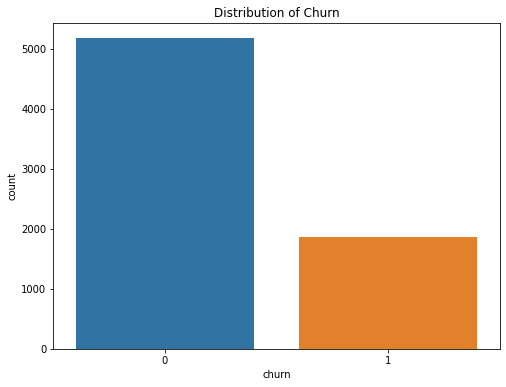

In [24]:
# Check the distribution of the 'Churn' variable
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='churn')
plt.title('Distribution of Churn')
plt.show()

The Churn variable is imbalanced, with more customers not churning than churning. This is something to keep in mind as we continue with our analysis and model building, as it might affect the performance of our model.

Let's explore the relationship between the categorical features and the Churn variable. We can do this by creating bar plots of the categorical variables, with the color indicating the proportion of customers who churned.

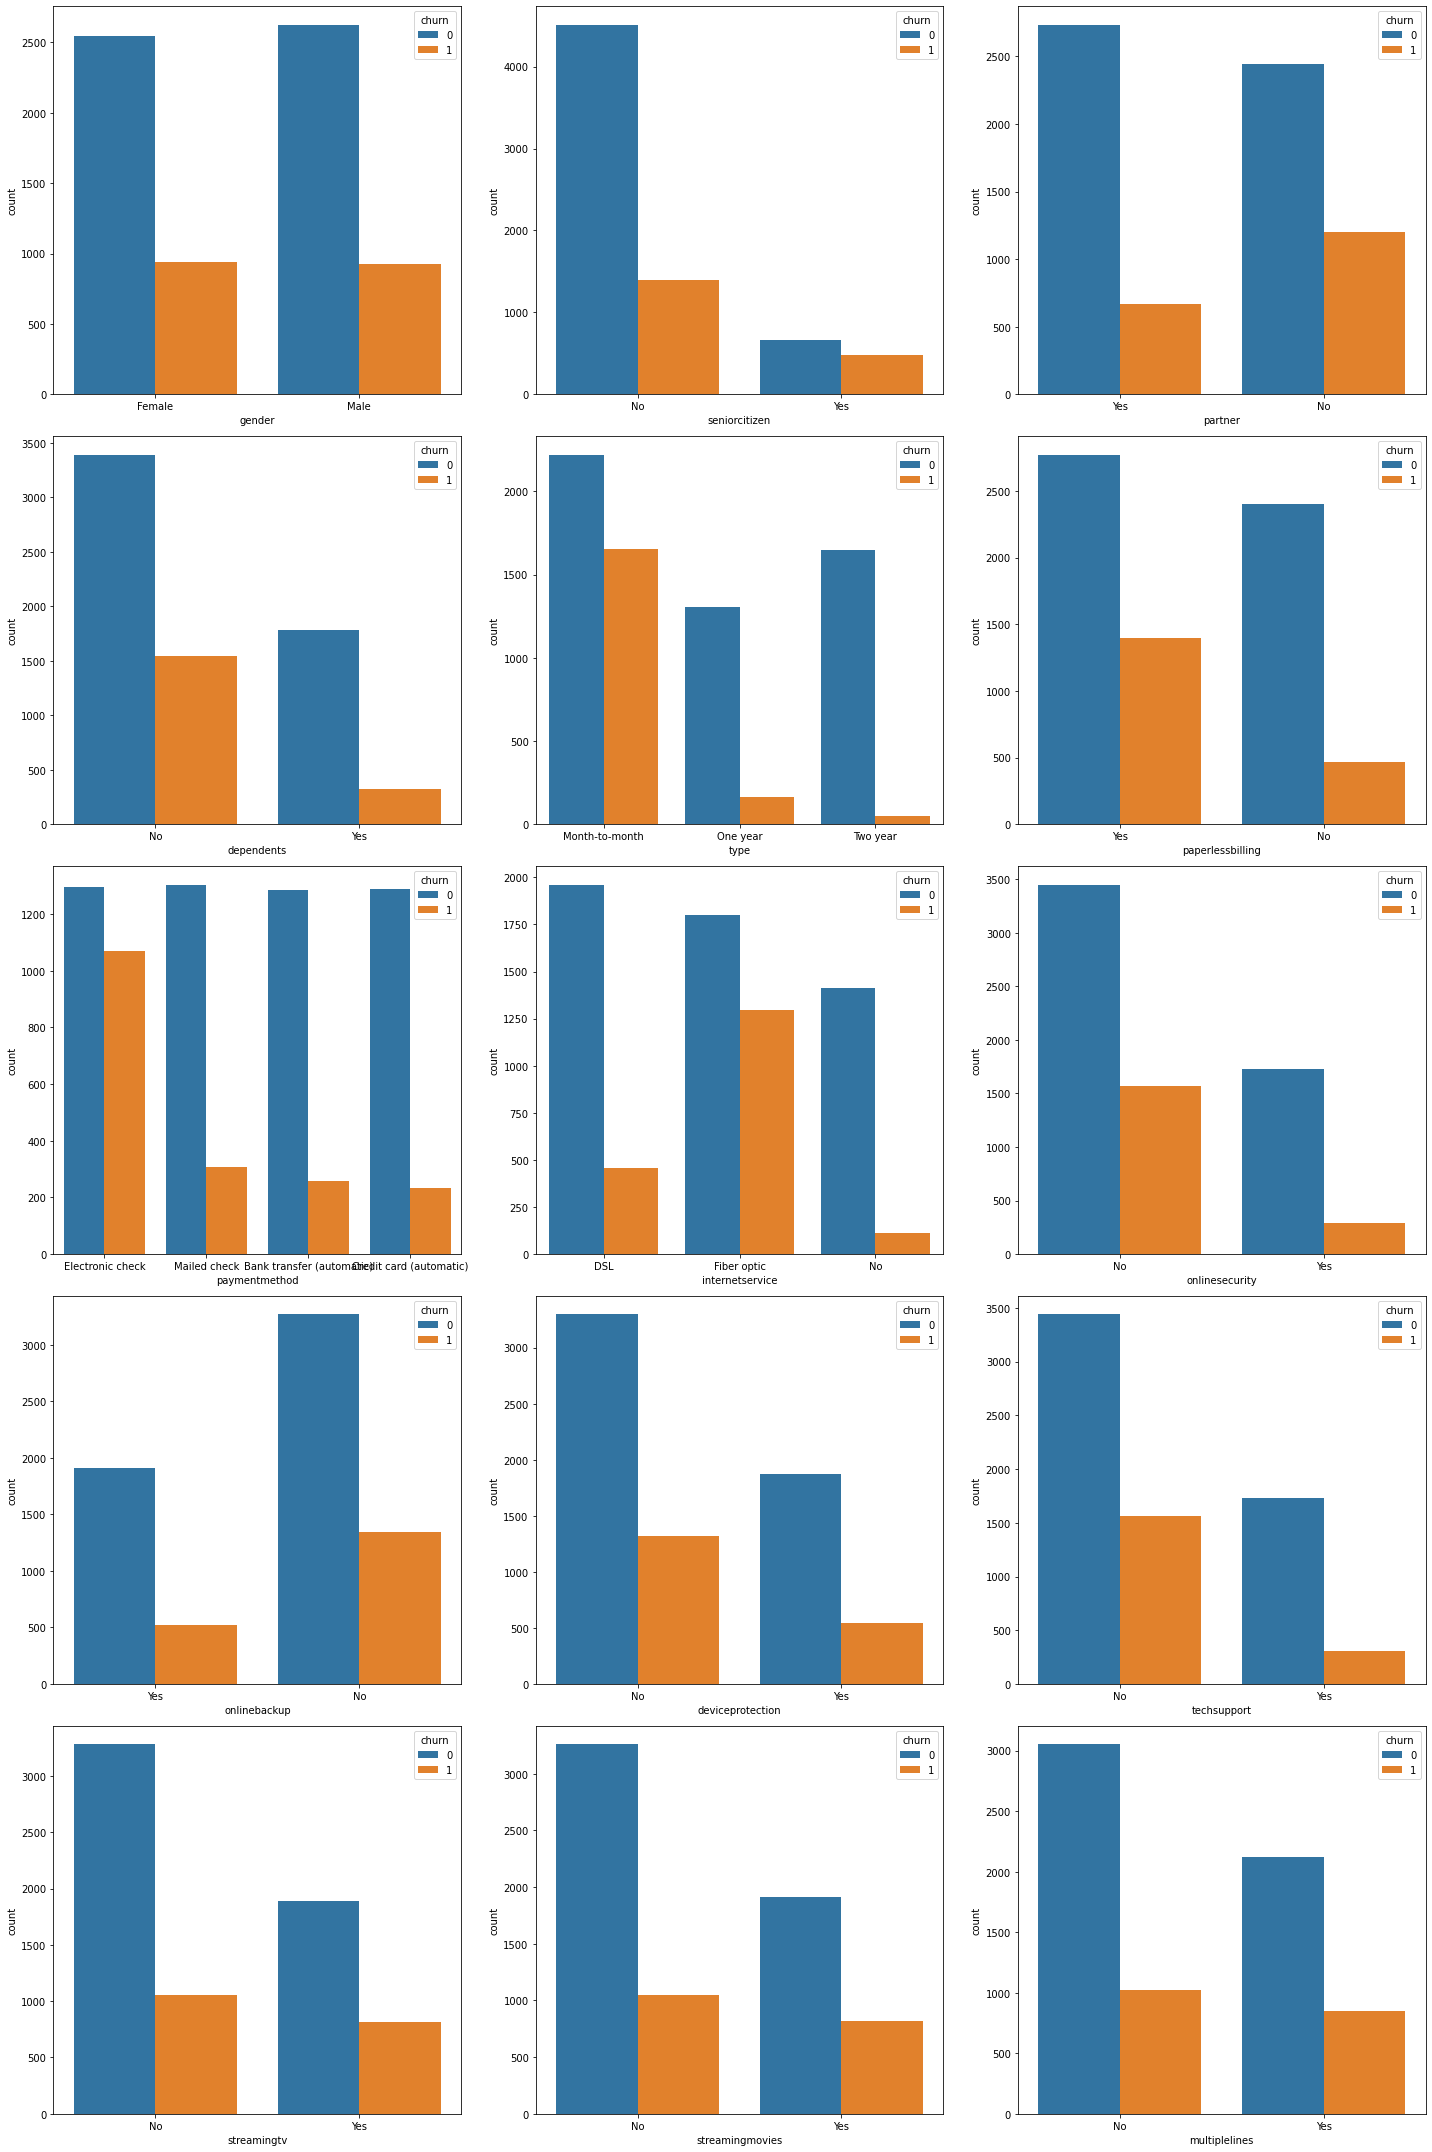

In [25]:
categorical_cols = ['gender', 'seniorcitizen', 'partner', 'dependents', 'type', 'paperlessbilling', 'paymentmethod', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,30))

# Create bar plots
for ax, col in zip(axes.flatten(), categorical_cols):
    sns.countplot(data=df, x=col, hue='churn', ax=ax)

plt.tight_layout()
plt.show()

The churn rate is observed to be higher among senior citizens, customers without a partner or dependents, those on month-to-month contracts, and customers using electronic checks, fiber optic services, and paperless billing, especially if they lack online security, online backup, device protection, or tech support. However, factors such as gender, having streaming services, and multiple lines do not seem to significantly influence the churn rate.

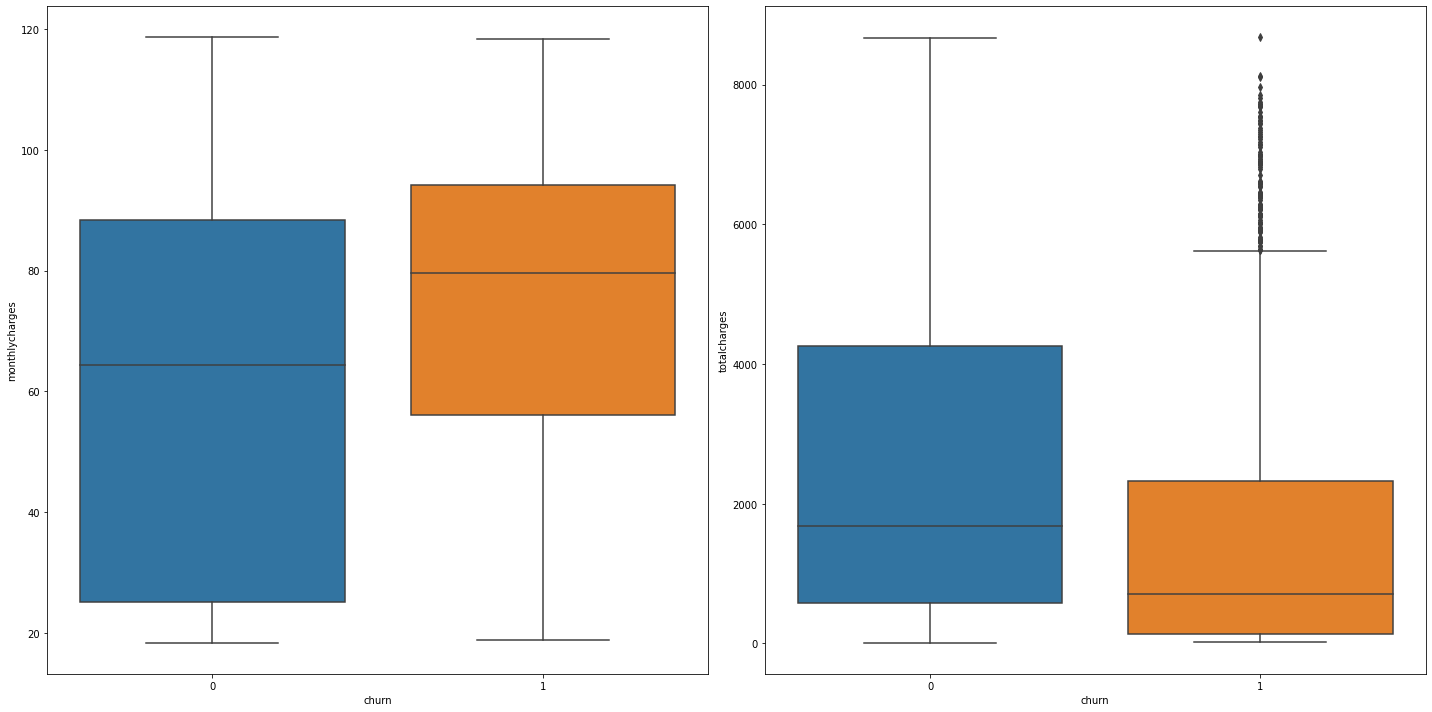

In [26]:
# List of numerical columns to plot
numerical_cols = ['monthlycharges', 'totalcharges']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Create box plots
for ax, col in zip(axes.flatten(), numerical_cols):
    sns.boxplot(data=df, y=col, x='churn', ax=ax)

plt.tight_layout()
plt.show()

- MonthlyCharges: Customers who churn tend to have higher monthly charges compared to those who don't churn. This could suggest that cost is a factor in a customer's decision to leave.
- TotalCharges: The total charges for customers who churn are generally lower compared to those who don't churn. This is likely due to these customers not staying long enough with the company to accumulate higher charges.

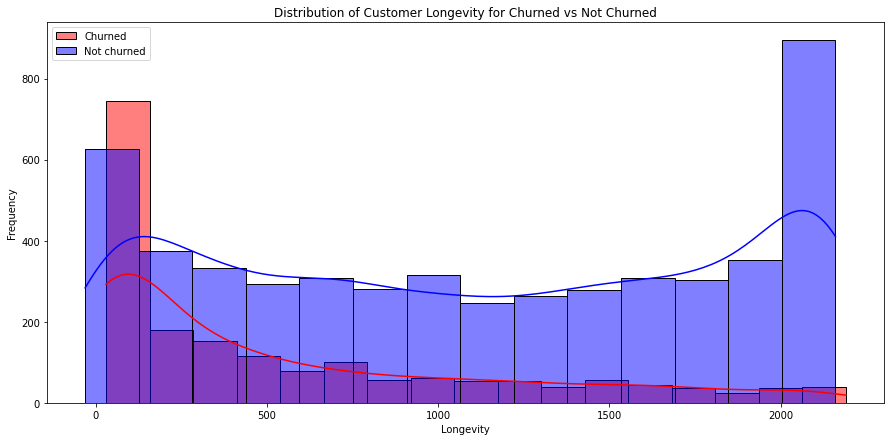

In [27]:
# Set the size of the plot
plt.figure(figsize=(15, 7))

# Create a distribution plot for longevity of customers who churned
sns.histplot(df[df['churn'] == 1]['longevity'], color='red', kde=True, label='Churned')

# Create a distribution plot for longevity of customers who did not churn
sns.histplot(df[df['churn'] == 0]['longevity'], color='blue', kde=True, label='Not churned')

# Set title and labels
plt.title('Distribution of Customer Longevity for Churned vs Not Churned')
plt.xlabel('Longevity')
plt.ylabel('Frequency')

# Show legend
plt.legend()

# Display the plot
plt.show()

- Customers who churned tend to have shorter longevity, they tend to leave the service relatively soon after joining.
- Customers who did not churn show a more uniform distribution across different longevity levels, with peaks around certain values, indicating they stay for longer periods.

This suggests that longevity might be a useful feature in predicting churn, as there seems to be a difference in the distribution of longevity between customers who churn and those who do not.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customerid           7043 non-null   object        
 1   gender               7043 non-null   object        
 2   seniorcitizen        7043 non-null   object        
 3   partner              7043 non-null   object        
 4   dependents           7043 non-null   object        
 5   begindate            7043 non-null   datetime64[ns]
 6   type                 7043 non-null   object        
 7   paperlessbilling     7043 non-null   object        
 8   paymentmethod        7043 non-null   object        
 9   monthlycharges       7043 non-null   float64       
 10  totalcharges         7043 non-null   float64       
 11  internetservice      7043 non-null   object        
 12  onlinesecurity       7043 non-null   object        
 13  onlinebackup         7043 non-nul

### PreProcessing for ML:

In [29]:
df = df.drop(columns=['customerid', 'begindate']) 

In [30]:
# Separate features and target variable
features = df.drop(['churn'], axis=1)
target = df['churn']

# Split the data into train and validation sets
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

# Define categorical columns for one-hot encoding
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define numerical columns for scaling
numerical_cols = features.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)])

# Fit the preprocessor and get the transformed training set
features_train_transformed = preprocessor.fit_transform(features_train)

# Get the transformed validation set
features_valid_transformed = preprocessor.transform(features_valid)

# Get the list of feature names after one-hot encoding for the categorical features
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names(categorical_cols)

# Combine the original numerical feature names with the new one-hot encoded feature names
new_feature_names = numerical_cols + list(ohe_feature_names)

# Convert the numpy arrays back to dataframes
features_train = pd.DataFrame(features_train_transformed, columns=new_feature_names)
features_valid = pd.DataFrame(features_valid_transformed, columns=new_feature_names)

features_train.shape, features_valid.shape

((5282, 23), (1761, 23))

In [31]:
features_train

,monthlycharges,totalcharges,longevity,additional_services,gender_Male,seniorcitizen_Yes,partner_Yes,dependents_Yes,type_One year,type_Two year,...,paymentmethod_Mailed check,internetservice_Fiber optic,internetservice_No,onlinesecurity_Yes,onlinebackup_Yes,deviceprotection_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,multiplelines_Yes
0,-1.475875,-0.885484,-0.735357,-1.114919,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.617064,1.674190,1.608613,1.599658,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,-0.482560,-0.678188,-0.775910,-0.572004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.749949,0.342904,0.168977,0.513827,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.836324,0.365290,0.047318,0.513827,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,0.143661,-0.948247,-1.269306,-1.114919,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5278,-1.188511,-0.972663,-1.228753,-0.572004,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5279,1.251589,2.317492,1.608613,1.056742,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
5280,-0.183568,-0.184034,0.006765,1.599658,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0


In [32]:
features_valid

,monthlycharges,totalcharges,longevity,additional_services,gender_Male,seniorcitizen_Yes,partner_Yes,dependents_Yes,type_One year,type_Two year,...,paymentmethod_Mailed check,internetservice_Fiber optic,internetservice_No,onlinesecurity_Yes,onlinebackup_Yes,deviceprotection_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,multiplelines_Yes
0,-1.514079,-0.782233,-0.241961,-1.114919,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.668557,-0.188868,-0.408229,-0.572004,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.221731,-0.984518,-1.270658,-1.114919,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.494145,-0.664148,-0.939474,-0.572004,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.831383,-0.564142,-0.282514,-0.029088,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,-0.019123,-0.876234,-1.146295,0.513827,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1757,0.253291,-0.948026,-1.269306,-1.114919,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1758,1.364542,1.943608,1.199026,1.056742,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
1759,0.215087,1.202884,1.608613,0.513827,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


### Function to Evaluate Models

In [33]:
# Function that can evaluate models with binary predictions and continuous predictions 
def evaluate_model(model, features, target, threshold=0.5, continuous_predictions=False):
    if continuous_predictions:
        # Make predictions
        probabilities = model.predict(features)
        
        # Convert probabilities into binary predictions
        predictions = [1 if prob > threshold else 0 for prob in probabilities]
    else:
        # Make predictions
        predictions = model.predict(features)

        # Calculate probabilities for the positive class
        probabilities = model.predict_proba(features)[:, 1]

    # Calculate accuracy, F1 score, and AUC-ROC
    accuracy = accuracy_score(target, predictions)
    f1 = f1_score(target, predictions)
    auc_roc = roc_auc_score(target, probabilities)

    # Return the results as a dictionary
    return {"Accuracy": accuracy, "F1 Score": f1, "AUC-ROC": auc_roc}

### Logistic Regression

In [34]:
# Create a Logistic Regression model
lr_model = LogisticRegression(random_state=12345, solver='liblinear', class_weight = 'balanced')

# Train the model
lr_model.fit(features_train, target_train)

#Evaluate model
evaluate_model(lr_model, features_valid, target_valid)

{'Accuracy': 0.7382169222032936,
 'F1 Score': 0.6199505358615004,
 'AUC-ROC': 0.8345299800996002}

Logistic Regression model achieved an accuracy score of 0.74, an F1 score of 0.62, and an AUC-ROC score of 0.83 on the validation set

### Decision Tree

In [35]:
# Create a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=12345, class_weight = 'balanced')

# Train the model
dt_model.fit(features_train, target_train)

#Evaluate model
evaluate_model(dt_model, features_valid, target_valid)

{'Accuracy': 0.8012492901760363,
 'F1 Score': 0.6292372881355933,
 'AUC-ROC': 0.746080572029939}

#### Hyperparameter Tuning

In [36]:
# Define the hyperparameter grid for the Random Forest model
dt_param_grid = {
    'max_depth': [None, 10, 20,30],
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object
dt_grid_search = GridSearchCV(dt_model, dt_param_grid, cv=5, scoring='roc_auc')

# Perform the grid search
dt_grid_search.fit(features_train, target_train)

# Get the best parameters and the best score
dt_best_params = dt_grid_search.best_params_
dt_best_score = dt_grid_search.best_score_

dt_best_params, dt_best_score

({'max_depth': 10, 'min_samples_split': 10}, 0.830230373123648)

#### Tuned Decision Tree Model

In [37]:
# Create a Decision Tree model with the best parameters
dt_best_model = DecisionTreeClassifier(**dt_best_params, random_state=12345, class_weight = 'balanced')

# Train the model
dt_best_model.fit(features_train, target_train)

#Evaluate model
evaluate_model(dt_best_model, features_valid, target_valid)

{'Accuracy': 0.7745599091425327,
 'F1 Score': 0.6538796861377507,
 'AUC-ROC': 0.8402951947255746}

Decision Tree model achieved an accuracy score of 0.8, an F1 score of 0.63, and an AUC-ROC score of 0.75 while tuning the model improved AUC-ROC to 0.84, F1 score to 0.65, and slighty lowering accuracy to 0.77

### Random Forest

In [38]:
# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=12345, class_weight = 'balanced')

# Train the model
rf_model.fit(features_train, target_train)

#Evaluate model
evaluate_model(rf_model, features_valid, target_valid)

{'Accuracy': 0.8154457694491766,
 'F1 Score': 0.6089049338146811,
 'AUC-ROC': 0.8666074900252115}

#### Hyperparameter Tuning

In [39]:
# Define the hyperparameter grid for the Random Forest model
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='roc_auc')

# Perform the grid search
rf_grid_search.fit(features_train, target_train)

# Get the best parameters and the best score
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_

rf_best_params, rf_best_score

({'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200},
 0.8652761880143919)

#### Tuned Random Forest Model

In [40]:
# Create a Random Forest model with the best parameters
rf_best_model = RandomForestClassifier(**rf_best_params, random_state=12345, class_weight = 'balanced')

# Train the model
rf_best_model.fit(features_train, target_train)

#Evaluate model
evaluate_model(rf_best_model, features_valid, target_valid)

{'Accuracy': 0.80465644520159,
 'F1 Score': 0.6748582230623819,
 'AUC-ROC': 0.8705064274684529}

Random Forest model achieved an accuracy score of 0.81, an F1 score of 0.61, and an AUC-ROC score of 0.87 while tuning the model improved F1 score to 0.67, marginally lower accuracy of 0.8 and same AUC-ROC of 0.87

### LightGBM

In [41]:
categorical_features = ['gender', 'seniorcitizen', 'partner', 'dependents', 'type', 'paperlessbilling', 'paymentmethod', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

df_lgbm = df.copy()

for col in categorical_features:
    df_lgbm[col] = df_lgbm[col].astype('category')
    
# Separate features and target variable
features = df_lgbm.drop(['churn'], axis=1)
target = df_lgbm['churn']

# Split the data into train and validation sets
features_train_lgbm, features_valid_lgbm, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

# Create a LightGBM data set
train_data = lgb.Dataset(features_train_lgbm, label=target_train, categorical_feature=categorical_features)

# Define parameters
params = {'objective': 'binary', 'metric': 'binary_logloss', 'is_unbalance': True, 'verbose': -1}

# Train the model
gbm = lgb.train(params, train_data)

#Evaluate model
evaluate_model(gbm, features_valid_lgbm, target_valid, continuous_predictions=True)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


{'Accuracy': 0.8205565019875071,
 'F1 Score': 0.6967370441458732,
 'AUC-ROC': 0.9011914011914012}

#### Hyperparameter Tuning

In [42]:
# Specify initial set of hyperparameters
param_grid = {
    'num_leaves': [20, 31, 40, 50],
    'max_depth': [10, 20, 30, 40],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [20, 40, 60, 80],
    'is_unbalance': [True]
}

lgb_estimator = lgb.LGBMClassifier()

# Create GridSearchCV object
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

gsearch.fit(features_train, target_train)

print('Best parameters found by grid search are:', gsearch.best_params_)
print('Best score found by grid search is:', gsearch.best_score_)

Best parameters found by grid search are: {'is_unbalance': True, 'learning_rate': 0.2, 'max_depth': 20, 'n_estimators': 80, 'num_leaves': 50}
Best score found by grid search is: 0.8967612382738015


#### Tuned LightGBM

In [43]:
# Create a LightGBM data set
train_data = lgb.Dataset(features_train_lgbm, label=target_train, categorical_feature=categorical_features)

# Define parameters
params = {**gsearch.best_params_, 'is_unbalance': True}

# Train the model
gbm_best_model = lgb.train(params, train_data)

#Evaluate model
evaluate_model(gbm_best_model, features_valid_lgbm, target_valid, continuous_predictions=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 19
[LightGBM] [Info] Start training from score 0.264105


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


{'Accuracy': 0.8597387847813742,
 'F1 Score': 0.7111111111111111,
 'AUC-ROC': 0.8814549257587233}

LightGBM achieved an accuracy score of 0.82, an F1 score of 0.7, and an AUC-ROC score of 0.9 while tuning the model improved F1 score to 0.71, accuracy to 0.86, and slightly lower AUC-ROC of 0.88

### Keras Neural Network

In [44]:
fcnn = Sequential()
fcnn.add(Dense(units=15, input_dim=features_train.shape[1], activation='tanh'))
fcnn.add(Dense(units=5, activation='tanh'))
fcnn.add(Dense(units=1, activation='sigmoid'))
fcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(name='auc')])

2023-07-29 03:18:59.686368: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [45]:
fcnn.fit(features_train, target_train, epochs=10, verbose=2, validation_data=(features_valid, target_valid))

Epoch 1/10
166/166 - 2s - loss: 0.5411 - auc: 0.7142 - val_loss: 0.4699 - val_auc: 0.8064 - 2s/epoch - 10ms/step
Epoch 2/10
166/166 - 1s - loss: 0.4395 - auc: 0.8313 - val_loss: 0.4521 - val_auc: 0.8208 - 537ms/epoch - 3ms/step
Epoch 3/10
166/166 - 1s - loss: 0.4299 - auc: 0.8386 - val_loss: 0.4475 - val_auc: 0.8247 - 581ms/epoch - 4ms/step
Epoch 4/10
166/166 - 1s - loss: 0.4255 - auc: 0.8412 - val_loss: 0.4440 - val_auc: 0.8264 - 519ms/epoch - 3ms/step
Epoch 5/10
166/166 - 1s - loss: 0.4228 - auc: 0.8425 - val_loss: 0.4407 - val_auc: 0.8287 - 571ms/epoch - 3ms/step
Epoch 6/10
166/166 - 1s - loss: 0.4198 - auc: 0.8444 - val_loss: 0.4423 - val_auc: 0.8277 - 529ms/epoch - 3ms/step
Epoch 7/10
166/166 - 1s - loss: 0.4184 - auc: 0.8452 - val_loss: 0.4408 - val_auc: 0.8285 - 561ms/epoch - 3ms/step
Epoch 8/10
166/166 - 1s - loss: 0.4166 - auc: 0.8464 - val_loss: 0.4388 - val_auc: 0.8299 - 524ms/epoch - 3ms/step
Epoch 9/10
166/166 - 1s - loss: 0.4153 - auc: 0.8469 - val_loss: 0.4392 - val_auc:

In [46]:
#Evaluate model
evaluate_model(fcnn, features_valid, target_valid, continuous_predictions=True)

{'Accuracy': 0.7836456558773425,
 'F1 Score': 0.5512367491166077,
 'AUC-ROC': 0.8307531661962042}

FCNN achieved an accuracy score of 0.79, F1 score of 0.57, and an AUC-ROC score of 0.83

LightGBM performed best out of all the models. Without tuning it has the highest AUC-ROC score of 0.9 while the tuned LightGBM model has 0.88 AUR-ROC but better F1 and accuracy. Either LightGBM models satisfy the requirement and it's up to Interconnect to decide if the improvement in F1 and accuracy is worth the small drop in AUC-ROC.

### Conclusions

1. Churn:
    - Customers with higher monthly charges are more likely to churn, indicating that cost is a significant factor in a customer's decision to leave.
    - Customers who have availed fewer services (like online security, device protection, etc.) are also more likely to churn.
    - Customers with shorter tenure are more likely to churn. They tend to leave the service relatively soon after joining.
    - Senior citizens and customers without a partner or dependents are more likely to churn.  

  
2. Best Model:
    - Based on the F1 scores and AUC-ROC scores, the LightGBM model performed the best. It achieved the highest scores among all the models tested.

  
3. Comparison between Trained Models:
    - Logistic Regression and Random Forest performed similarly, but LightGBM outperformed both. The Decision Tree model had the poorest performance, and the Fully Connected Neural Network (FCNN) performed moderately.
    - After hyperparameter tuning, the performance of the Decision Tree and Random Forest models improved, but they still couldn't surpass LightGBM.
    - FCNN model achieved decent results, but it didn't outperform the LightGBM model.

  
4. Suggestions to Reduce Churn:
    - Offering discounts or more cost-effective plans could help retain customers who feel that the service is too expensive.
    - Encouraging customers to use more services could also help. The company could offer bundle deals or special promotions.
    - For customers with shorter tenure, the company could offer incentives that encourage them to stay longer, like loyalty rewards or discounts for long-term contracts.